# Jumping to Conclusions

This is one of the Jupyter notebooks I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*.

The book is scheduled to be published by University of Chicago Press in 2023.
If you would like to get infrequent email announcements about the book, please
[sign up for my mailing list](http://eepurl.com/h0nfbX).

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/berkson.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

In 1986, Michael Anthony Jerome "Spud" Webb was the shortest player in the National Basketball Association (NBA);
he was 5 feet 6 inches (168 cm). 
Nevertheless, that year he won the NBA Slam Dunk Contest after successfully executing the elevator two-handed double pump dunk and the reverse two-handed strawberry jam.

This performance was possible because Webb's vertical leap was at least 42 inches (107 cm), bringing the top of his head to 9 feet (275 cm) and his outstretched hand well above the basketball rim at 10 feet (305 cm).

During the same year, I played intercollegiate volleyball at the Massachusetts Institute of Technology (MIT).
Although the other players and I were less elite athletes than Spud Webb, I noticed a similar relationship between height and vertical leap.
Consistently, the shorter players on the team jumped higher than the taller players.

At the time, I wondered if there might be a biokinetic reason for the relationship: maybe shorter legs provide some kind of mechanical advantage.
It turns out that there is no such reason; according to a 2003 paper on physical characteristics that predict jumping ability, there is "no significant relationship" between body height and vertical leap.

By now, you have probably figured out the error in my thinking.
In order to play competitive volleyball, it helps to be tall.
If you are not tall, it helps if you can jump.
If you are not tall and can't jump, you probably don't play competitive volleyball, you don't play in the NBA, and you definitely don't win a slam dunk contest.

In the general population, there is no correlation between height and jumping ability, but intercollegiate athletes are not a representative sample of the population, and elite athletes even less so.
They have been selected based on their height and jumping ability, and the selection process creates the relationship between these traits.

This phenomenon is called Berkson's paradox after a researcher who wrote about it in 1946.
I'll present his findings later, but first let's look at another example from college.

## Math and Verbal Skills

Among students at a given college or university, do you think math and verbal skills are correlated, anti-correlated, or uncorrelated?
In other words, if someone is above average at one of these skills, would you expect them to be above average on the other, or below average, or do you think they are unrelated?

To answer this question, I will use data from the National Longitudinal Survey of Youth 1997 (NLSY97), which "follows the lives of a sample of 8,984 American youth born between 1980-84". 
The public data set includes the participants' scores on several standardized tests, including the tests most often used in college admissions, the SAT and ACT.

I used the [NLS Investigator](https://www.nlsinfo.org/investigator/pages/login) to create excerpt that contains the variables I'll use for this analysis. With their permission, I can redistribute this except. The following cell downloads the data.

In [4]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

download(DATA_PATH + "stand_test_corr.csv.gz")

In [5]:
df = pd.read_csv("stand_test_corr.csv.gz")
df.shape

(8984, 29)

In [6]:
df.head()

,R0000100,R0536300,R0536401,R0536402,R1235800,R1482600,R5473600,R5473700,R7237300,R7237400,...,R9794001,R9829600,S1552600,S1552700,Z9033700,Z9033800,Z9033900,Z9034000,Z9034100,Z9034200
0,1,2,9,1981,1,4,-4,-4,-4,-4,...,1998,45070,-4,-4,4,3,3,2,-4,-4
1,2,1,7,1982,1,2,-4,-4,-4,-4,...,1998,58483,-4,-4,4,5,4,5,-4,-4
2,3,2,9,1983,1,2,-4,-4,-4,-4,...,-4,27978,-4,-4,2,4,2,4,-4,-4
3,4,2,2,1981,1,2,-4,-4,-4,-4,...,-4,37012,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,10,1982,1,2,-4,-4,-4,-4,...,-4,-4,-4,-4,2,3,6,3,-4,-4


The [columns are documented in the codebook](https://www.nlsinfo.org/investigator/pages/search?s=NLSY97).  The following dictionary maps the current column names to more memorable names. 

In [7]:
d = {
    "R9793200": "psat_math",
    "R9793300": "psat_verbal",
    "R9793400": "act_comp",
    "R9793500": "act_eng",
    "R9793600": "act_math",
    "R9793700": "act_read",
    "R9793800": "sat_verbal",
    "R9793900": "sat_math",
    # 'B0004600': 'college_gpa',
}

df.rename(columns=d, inplace=True)

For this analysis I'll use only the SAT math and verbal scores. If you are curious, you could do something similar with ACT scores.

In [8]:
varnames = ["sat_verbal", "sat_math"]

for varname in varnames:
    invalid = df[varname] < 200
    df.loc[invalid, varname] = np.nan

In this cohort, about 1400 participants took the SAT.
Their average scores were 502 on the verbal section and 503 on the math section, both close to the national average, which is calibrated to be 500.

The standard deviation of their scores was 108 on the verbal section and 110 on the math section, both a little higher than the overall standard deviation, which is calibrated to be 100.

In [9]:
df["sat_verbal"].describe()

count    1400.000000
mean      501.678571
std       108.343678
min       200.000000
25%       430.000000
50%       500.000000
75%       570.000000
max       800.000000
Name: sat_verbal, dtype: float64

In [10]:
df["sat_math"].describe()

count    1399.000000
mean      503.213009
std       109.901382
min       200.000000
25%       430.000000
50%       500.000000
75%       580.000000
max       800.000000
Name: sat_math, dtype: float64

In [11]:
df[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.734739
sat_math,0.734739,1.000000


To show how the scores are related, here's a scatter plot showing a data point for each participant, with verbal scores on the horizontal axis and math scores on the vertical. 

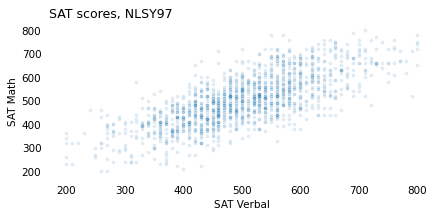

In [12]:
plt.plot(df["sat_verbal"], df["sat_math"], ".", ms=5, alpha=0.1)

decorate(xlabel="SAT Verbal", ylabel="SAT Math", title="SAT scores, NLSY97")

People who do well on one section tend to do well on the other.
The correlation between scores is 0.73, so someone who is one standard deviation above the mean on the verbal test is expected to be 0.73 standard deviations above the mean on the math test. For example, if you select people whose verbal score is near 600, which is 100 points above the mean, the average of their math scores is 570, about 70 points above the mean.

In [13]:
near600 = (df["sat_verbal"] >= 550) & (df["sat_verbal"] <= 650)
df.loc[near600, "sat_math"].mean()

572.4468085106383

## Elite University

Consider an imaginary institution of higher learning called Elite University.
To be admitted to E.U., let's suppose, your total SAT score (sum of the verbal and math scores) has to be 1320 or higher. 

In [14]:
sat_total = df["sat_verbal"] + df["sat_math"]
sat_total.describe()

count    1398.000000
mean     1004.892704
std       203.214916
min       430.000000
25%       860.000000
50%      1000.000000
75%      1140.000000
max      1580.000000
dtype: float64

In [15]:
admitted = df.loc[sat_total >= 1320]
rejected = df.loc[sat_total < 1320]
admitted[varnames].describe()

,sat_verbal,sat_math
count,95.000000,95.000000
mean,699.894737,698.947368
std,53.703178,46.206606
min,550.000000,580.000000
25%,660.000000,660.000000
50%,700.000000,710.000000
75%,735.000000,730.000000
max,800.000000,800.000000


If we select participants from the NLSY who meet this requirement, their average score on both sections is about 700, the standard deviation is about 50, and the correlation of the two scores is -0.33.
So if someone is one standard deviation above the E.U. mean on one test, we expect them to be one third of a standard deviation *below* the mean on the other, on average.
For example, if you meet an E.U. student who got a 760 on the verbal section (60 points above the E.U. mean), you would expect them to get a 680 on the math section (20 points below the mean).

In the population of test takers, the correlation between scores is positive.
But in the population of E.U. students, the correlation is negative.
The following figure shows how this happens.

In [16]:
admitted[["sat_verbal", "sat_math"]].corr()

,sat_verbal,sat_math
sat_verbal,1.0000,-0.3353
sat_math,-0.3353,1.0000


In [17]:
from scipy.stats import linregress

res = linregress(admitted["sat_verbal"], admitted["sat_math"])
xs = np.linspace(600, 800)
ys = res.intercept + res.slope * xs

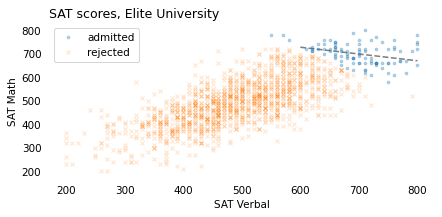

In [18]:
plt.plot(xs, ys, "--", color="gray")

plt.plot(
    admitted["sat_verbal"], admitted["sat_math"], ".", label="admitted", ms=5, alpha=0.3
)
plt.plot(
    rejected["sat_verbal"], rejected["sat_math"], "x", label="rejected", ms=3, alpha=0.2
)

decorate(xlabel="SAT Verbal", ylabel="SAT Math", title="SAT scores, Elite University")

The circles in the upper right show students who meet the requirement for admission to Elite University.
The dashed line shows the average math score for students at each level of verbal score.
If you meet someone at E.U. with a relatively low verbal score, you expect them to have a high math score. Why? Because otherwise, they would not be at Elite University.
And conversely, if you meet someone with a relatively low math score, they must have a high verbal score.

## Less Elite, More Correlated

Of course, not all colleges require a total SAT score of 1320.
Most are less selective, and some don't consider standardized test scores at all.

So let's see what happens to the correlation between math and verbal scores as we vary admission requirements.
As in the previous example, I'll use a model of the selection process that will annoy anyone who works in college admission: 

* Suppose that every college has a simple threshold for the total SAT score. Any applicant who exceeds that threshold will be offered admission.

* And suppose that the students who accept the offer are a random sample from the ones who are admitted.

The following figure shows a range of thresholds on the horizontal axis, from a total score of 700 up to 1400.
On the vertical axis, it shows the correlation between math and verbal scores among the students whose scores exceed the threshold, based on the NLSY data.

In [19]:
corr_series = pd.Series([], dtype=float)

for thresh in np.arange(700, 1450, 50):
    admitted = df.loc[sat_total >= thresh]
    mean = admitted[varnames].mean().sum()
    corr = admitted[["sat_verbal", "sat_math"]].corr()
    corr_series[thresh] = corr.iloc[0][1]

corr_series

700     0.685154
750     0.661058
800     0.620211
850     0.576750
900     0.519278
950     0.452663
1000    0.392761
1050    0.301356
1100    0.193192
1150    0.087910
1200   -0.019167
1250   -0.102005
1300   -0.245565
1350   -0.323388
1400   -0.413395
dtype: float64

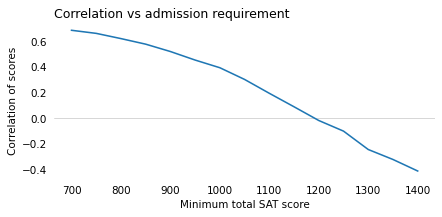

In [20]:
plt.axhline(0, color="0.7", lw=0.5)
corr_series.plot(label="")
# plt.plot(1320, -0.33, '^', color='C0')

decorate(
    xlabel="Minimum total SAT score",
    ylabel="Correlation of scores",
    title="Correlation vs admission requirement",
)

At a college that requires a total score of 700, math and verbal scores are positively correlated.
At a selective college where the threshold is around 1200, the correlation is close to 0.  And at an elite school where the threshold is over 1300, the correlation is negative.

## Secondtier College

Suppose at Secondtier College (it's pronounced "se-con-tee-ay"), a student with a total score of 1200 or more is admitted, but a student with 1300 or more is likely to go somewhere else.

Using data from the NLSY again, the following figure shows the verbal and math score for applicants in three groups: rejected, enrolled, and the ones who were accepted but went somewhere else. 

In [21]:
rejected = df.loc[sat_total < 1200]
rejected.shape

(1138, 29)

In [22]:
elsewhere = df.loc[sat_total >= 1300]
elsewhere.shape

(118, 29)

In [23]:
enrolled = df.loc[(sat_total >= 1200) & (sat_total < 1300)]
enrolled.shape

(142, 29)

In [24]:
from scipy.stats import linregress

res = linregress(enrolled["sat_verbal"], enrolled["sat_math"])
xs = np.linspace(500, 730)
ys = res.intercept + res.slope * xs

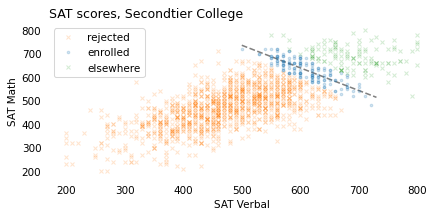

In [25]:
plt.plot(xs, ys, "--", color="gray")

plt.plot(
    rejected["sat_verbal"],
    rejected["sat_math"],
    "x",
    label="rejected",
    ms=3,
    alpha=0.2,
    color="C1",
)
plt.plot(
    enrolled["sat_verbal"],
    enrolled["sat_math"],
    ".",
    label="enrolled",
    ms=5,
    alpha=0.2,
    color="C0",
)
plt.plot(
    elsewhere["sat_verbal"],
    elsewhere["sat_math"],
    "x",
    label="elsewhere",
    ms=3,
    alpha=0.2,
    color="C2",
)

decorate(xlabel="SAT Verbal", ylabel="SAT Math", title="SAT scores, Secondtier College")

Among the students who enrolled, the correlation between math and verbal scores is strongly negative, about -0.84.

In [26]:
enrolled[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,-0.843266
sat_math,-0.843266,1.000000


In [27]:
enrolled[varnames].describe()

,sat_verbal,sat_math
count,142.000000,142.000000
mean,608.661972,631.267606
std,42.846069,49.045632
min,500.000000,480.000000
25%,572.500000,600.000000
50%,600.000000,630.000000
75%,640.000000,670.000000
max,720.000000,720.000000


In [28]:
near650 = (enrolled["sat_verbal"] > 630) & (df["sat_verbal"] < 680)
df.loc[near650, "sat_verbal"].mean()

651.25

In [29]:
df.loc[near650, "sat_math"].mean()

590.0

At Secondtier, if you meet a student who got 650 on the verbal section, about 50 points above the mean, you should expect them to get 590 on the verbal section, about 40 points below the mean.

So we have the answer to the question I posed: depending on how colleges select students, math and verbal scores might be correlated, unrelated, or anti-correlated. 

## Berkson's Paradox in Hospital Data

Berkson's paradox is named for Joseph Berkson, who led the Division of Biometry and Medical Statistics at the Mayo Clinic in Rochester, Minnesota.
In 1946, he wrote a paper pointing out the danger of using patients in a clinic or hospital as a sample.

As an example, he uses the relationship between cholecystic disease (inflammation of the gall bladder) and diabetes.
At the time, these conditions were thought to be related so that, "in certain medical circles, the gall bladder was being removed as a treatment for diabetes."
His tone suggests what he thinks of these "medical circles".

Berkson showed that the apparent relationship between the two conditions might be the result of using hospital patients as a sample.
To demonstrate the point, he generated a simulated population where 1% have diabetes, 3% have cholecystitis, and the conditions are unrelated; that is, having one condition does not, in fact, change the probability of having the other.

Then he simulated what happens if we use hospital patients as a sample.
He assumes that people with either condition are more likely to go to the hospital, and therefore more likely to appear in the hospital sample, compared to people with neither condition.

In the hospital sample, he finds that there is a negative correlation between the conditions; that is, people with cholecystitis are less likely to have diabetes.

I'll demonstrate with a simplified version of Berkson's experiment.
Consider a population of one million people where 1% have diabetes, 3% have cholecystitis, and the conditions are unrelated.
We'll assume that someone with either condition has a 5% chance of appearing in the hospital sample, and someone with neither condition has a 1% chance.

Here are the proportions as specified in the example.

In [30]:
p_d = 0.01
p_c = 0.03

To make the table, it is helpful to define the complementary proportions, too.

In [31]:
q_d = 1 - p_d
q_c = 1 - p_c

Now here are the fraction of people in each quadrant of the "four-fold table".

In [32]:
df = (
    pd.DataFrame(
        data=[[p_c * p_d, p_c * q_d], [q_c * p_d, q_c * q_d]],
        index=["C", "No C"],
        columns=["D", "No D"],
    )
    * 1_000_000
)

df = df.transpose()
df

,C,No C
D,300.0,9700.0
No D,29700.0,960300.0


In [33]:
df["C"] / df.sum(axis=1)

D       0.03
No D    0.03
dtype: float64

Here are the probabilities that a patient appears in the hospital sample, given that they have one of the conditions.

In [34]:
s_d = 0.05
s_c = 0.05

In [35]:
df.stack()

D     C          300.0
      No C      9700.0
No D  C        29700.0
      No C    960300.0
dtype: float64

So here are the probabilities for each of the four quadrants.

In [36]:
f = [1 - (1 - s_d) * (1 - s_c), s_c, s_d, 0.01]
f

[0.09750000000000003, 0.05, 0.05, 0.01]

Now we can compute the number of people from each quadrant we expect to see in the hospital sample.

In [37]:
enum = pd.DataFrame(dict(number=df.stack(), f=f))
enum["expected"] = enum["number"] * enum["f"]
enum

number       f  expected
D    C        300.0  0.0975     29.25
     No C    9700.0  0.0500    485.00
No D C      29700.0  0.0500   1485.00
     No C  960300.0  0.0100   9603.00

In [38]:
hospital = enum["expected"].unstack()
hospital

,C,No C
D,29.25,485.0
No D,1485.00,9603.0


If we simulate this sampling process, we can compute the number of people in the hospital sample with and without cholecystitis, and with and without diabetes.
The following table shows the results in the form of what Berkson calls a "fourfold table".

In [39]:
hospital["Total"] = hospital.sum(axis=1)
hospital.round().astype(int)

,C,No C,Total
D,29,485,514
No D,1485,9603,11088


The columns labeled "C" and "No C" represent hospital patients with and without cholecystitis; the rows labeled "D" and "No D" represent patients with and without diabetes.
The results indicate that, from a population of one million people:

* We expect a total 514 people with diabetes (top row) to appear in a sample of hospital patients; of them, we expect 29 to also have cholecystitis, and

* We expect 11,088 people without diabetes (bottom row) to appear in the sample; of them, we expect 1485 to have cholecystitis.

In [40]:
hospital["C"] / hospital["Total"]

D       0.056879
No D    0.133929
dtype: float64

If we compute the rate in each row, we find:

* In the group with diabetes, about 5.6% have cholecystitis, and

* In the group without diabetes, about 13% have cholecystitis.

So in the sample, the correlation between the conditions is negative: if you have diabetes, you are substantially less likely to have cholecystitis.
But we know that there is no such relationship in the simulated population, because we designed it that way. So why does this relationship appear in the hospital sample?

Here are the pieces of the explanation:

* People with either condition are more likely to go to the hospital, compared to people with neither condition.

* If you find someone at the hospital who has cholecystitis, that's likely to be the reason they are in the hospital.

* If they *don't* have cholecystitis, they are probably there for another reason, so they are more likely to have diabetes.

That's the end of the computational part of this chapter; the other examples are narrative.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).